In [4]:
import uproot4
import numpy as np
import pandas as pd
import numba
import seaborn as sns
import awkward as ak
from scipy.stats import norm
from scipy.optimize import curve_fit
from coffea import hist
from coffea.processor import defaultdict_accumulator
import os
import copy

import optparse
import importlib
import pathlib

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
plt.style.use(hep.style.ROOT)

#Just to efficiently save plots
plot_dir = "plot/"
from datetime import datetime
now = datetime.now()
dt_string = now.strftime("%d-%m-%Y")
save_path = plot_dir + dt_string

print("Saving plots to: ", save_path)

#Plot settings
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'small',
         'axes.labelsize': 'large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

#line thickness
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 5

## Data processing codes
def getData(fname="", treeName="Truth"):
    dq_dict_ak1 = uproot4.lazy(fname+":"+treeName)
    dq_events = ak.zip({
                        "nTrack": ak.zip({
                                "n_tracks": dq_dict_ak1['n_tracks']
                        }),
                        "event_weight": ak.zip({
                                'weight': dq_dict_ak1['weight']
                        }),
        
                        "GenVertex": ak.zip({
                                            "x": dq_dict_ak1["gvx"],
                                            "y": dq_dict_ak1["gvy"],
                                            "z": dq_dict_ak1["gvz"],
                                            "px": dq_dict_ak1["gpx"],
                                            "py": dq_dict_ak1["gpy"],
                                            "pz": dq_dict_ak1["gpz"]

                        }),
                        "GenP_St1": ak.zip({
                                            "px": dq_dict_ak1["gpx_st1"],
                                            "py": dq_dict_ak1["gpy_st1"],
                                            "pz": dq_dict_ak1["gpz_st1"],
                                            "x": dq_dict_ak1["gx_st1"],
                                            "y": dq_dict_ak1["gy_st1"],
                                            "z": dq_dict_ak1["gz_st1"],
                        }),
                        "Track_St1": ak.zip({
                                            "px": dq_dict_ak1["track_px_st1"],
                                            "py": dq_dict_ak1["track_py_st1"],
                                            "pz": dq_dict_ak1["track_pz_st1"],
                                            "x": dq_dict_ak1["track_x_st1"],
                                            "y": dq_dict_ak1["track_y_st1"],
                                            "z": dq_dict_ak1["track_z_st1"],
                        }),
        
                        "hit": ak.zip({
                                            "pos": dq_dict_ak1['hit_pos'],
                                            "detID": dq_dict_ak1['hit_detID'],
                        }),
                        "fpga_trigger": ak.zip({"trigger": dq_dict_ak1["fpga_trigger"]
                            
                        }),
                       }, depth_limit=1)
    return dq_events

def log_inf(i):
    return None if i == 0 else np.log(i) 

def plot_acceptance(mass, coupling, Nevent, acceptance, hue_norm = (0,1)):
    
    fig, ax = plt.subplots()
    im = ax.scatter(mass, coupling, c=acceptance, s=900, marker='s', cmap='Spectral_r',linewidths=0)

    fig.colorbar(im, ax=ax)

    plt.xlabel(r"$m_{A'}$ [GeV]")
    plt.ylabel(ylabel=r"$\epsilon$", rotation = 0)

    # iterate over axes of FacetGrid
    labels = ax.get_yticks() # get y labels

    new_labels = []
    for i,l in enumerate(labels):
        new_labels.append(r"$10^{%s}$"%labels[i])

    ax.set_yticklabels(new_labels) # set new labels

#     plt.show()

######## READ EVENTS
scan_dir = "/mnt/T2_US_MIT/hadoop/mitgroups/DarkQuest/dhoang/Aprime_Muons_Scan_17_04_2022/"

Saving plots to:  plot/18-04-2022


## 0. Tracking reconstuction efficiency (fraction of events that have 2 tracks)

In [2]:
def scan_Ap_0(scan_dir):
    mass = []
    coupling = []
    Nevent = []
    acceptance = []

    #Loop through the files
    for filename in os.listdir(scan_dir):
        if filename.startswith("Brem") & (not filename.endswith("_DST.root")):
            
            #print(filename)
            
            #Parse some basic info
            Ap_config = filename[:-5].split('_') #Remove the .root part and split by '_'
            
#             try:
            #Load file and calculate total number of events
            dq_events = getData(os.path.join(scan_dir, filename), 'Events')

            #Total events
            n_events = len(dq_events["GenVertex"].x)
            Nevent.append(n_events)

            #Number of events reconstructed but not triggered
            n_reco = ak.sum((ak.count(dq_events["Track_St1"].x, axis = 1) == 2)*dq_events['event_weight'].weight)

            mass.append(float(Ap_config[1]))
            coupling.append(float(Ap_config[-1]))
            acceptance.append(n_reco/n_events if n_events > 0 else 0)
            
#             except:
#                 continue
            
#             print("---"*5)
#             print("Mass: ", Ap_config[1])
#             print("Coupling: ", Ap_config[-1])
#             print("Total number of events: ", n_events)
#             print("Number of events reconstructed", n_reco)
            
    return mass, coupling, Nevent, acceptance
            
mass_0, coupling_0, Nevent_0, acceptance_0 = scan_Ap_0(scan_dir)

KeyboardInterrupt: 

/tmp/ipykernel_2241944/3057667214.py:126: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(new_labels) # set new labels


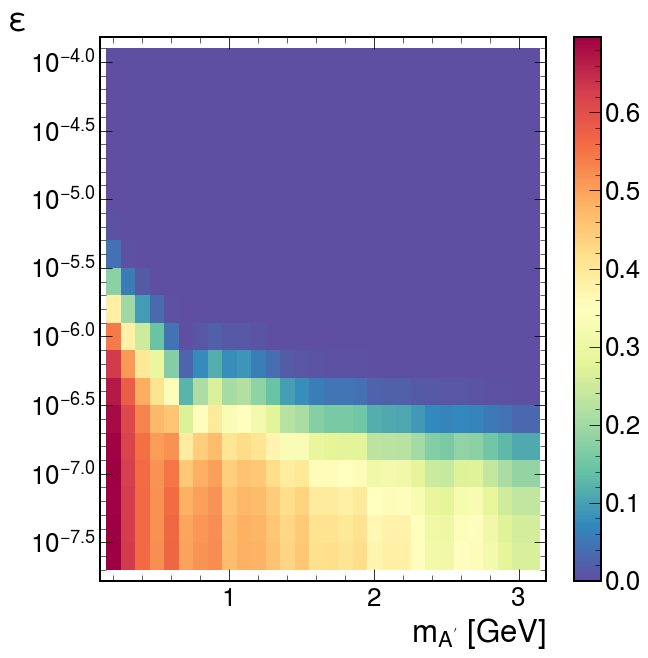

plot/18-04-2022DP_track_accept_muons.pdf


<Figure size 720x720 with 0 Axes>

In [6]:
plot_acceptance(mass_0, coupling_0, Nevent_0, acceptance_0)

plt.savefig(save_path + "DP_track_accept_muons.pdf", bbox_inches='tight')
print(save_path + "DP_track_accept_muons.pdf")

## 1. Fail all

In [4]:
def scan_Ap_1(scan_dir):
    mass = []
    coupling = []
    Nevent = []
    acceptance = []

    #Loop through the files
    for filename in os.listdir(scan_dir):
        if filename.startswith("Brem"):
            
            #print(filename)
            
            #Parse some basic info
            Ap_config = filename[:-5].split('_') #Remove the .root part and split by '_'
            
            try:
                #Load file and calculate total number of events
                dq_events = getData(os.path.join(scan_dir, filename), 'Events')

                #Total events
                n_events = len(dq_events["GenVertex"].x)
                Nevent.append(n_events)

                #Number of events reconstructed but not triggered
                n_reco = ak.sum(((~(ak.count(dq_events["Track_St1"].x, axis = 1) == 2)) &\
                                (~(dq_events["fpga_trigger"].trigger[:,0] == 1)))*dq_events['event_weight'].weight)
                
                mass.append(float(Ap_config[1]))
                coupling.append(float(Ap_config[-1]))
                acceptance.append(n_reco/n_events if n_events > 0 else 0)
            
            except:
                continue
            
#             print("---"*5)
#             print("Mass: ", Ap_config[1])
#             print("Coupling: ", Ap_config[-1])
#             print("Total number of events: ", n_events)
#             print("Number of events reconstructed", n_reco)
            
    return mass, coupling, Nevent, acceptance
            
mass_1, coupling_1, Nevent_1, acceptance_1 = scan_Ap_1(scan_dir)

/tmp/ipykernel_89756/1226374672.py:126: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(new_labels) # set new labels


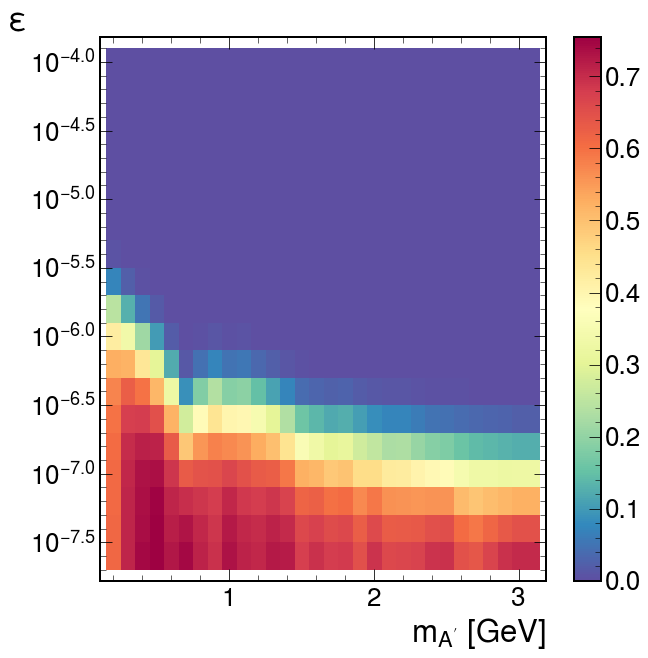

In [5]:
plot_acceptance(mass_1, coupling_1, Nevent_1, acceptance_1)

## 2. Pass track but not trigger

In [6]:
def scan_Ap_2(scan_dir):
    mass = []
    coupling = []
    Nevent = []
    acceptance = []

    #Loop through the files
    for filename in os.listdir(scan_dir):
        if filename.startswith("Brem"):
            
            #Parse some basic info
            Ap_config = filename[:-5].split('_') #Remove the .root part and split by '_'
            
            try:
                #Load file and calculate total number of events
                dq_events = getData(os.path.join(scan_dir, filename), 'Events')

                #Total events
                n_events = len(dq_events["GenVertex"].x)
                Nevent.append(n_events)

                #Number of events reconstructed but not triggered
                n_reco = ak.sum(((ak.count(dq_events["Track_St1"].x, axis = 1) == 2) &\
                                (~(dq_events["fpga_trigger"].trigger[:,0] == 1)))*dq_events['event_weight'].weight)
                
                mass.append(float(Ap_config[1]))
                coupling.append(float(Ap_config[-1]))
                acceptance.append(n_reco/n_events if n_events > 0 else 0)
            
            except:
                continue
            
#             print("---"*5)
#             print("Mass: ", Ap_config[1])
#             print("Coupling: ", Ap_config[-1])
#             print("Total number of events: ", n_events)
#             print("Number of events reconstructed", n_reco)
            
    return mass, coupling, Nevent, acceptance
            
mass_2, coupling_2, Nevent_2, acceptance_2 = scan_Ap_2(scan_dir)

/tmp/ipykernel_89756/1226374672.py:126: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(new_labels) # set new labels


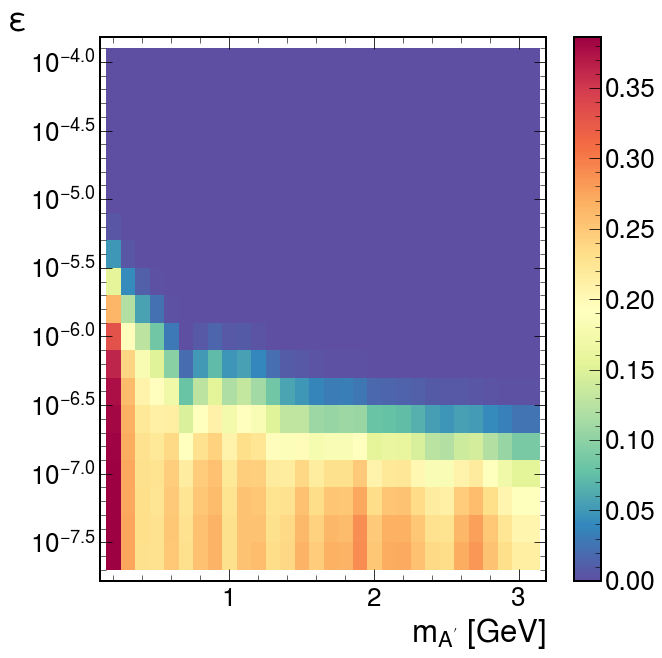

In [7]:
plot_acceptance(mass_2, coupling_2, Nevent_2, acceptance_2)

## 3. Pass trigger but not track

In [8]:
def scan_Ap_3(scan_dir):
    mass = []
    coupling = []
    Nevent = []
    acceptance = []

    #Loop through the files
    for filename in os.listdir(scan_dir):
        if filename.startswith("Brem"):
            
            try:
                #Parse some basic info
                Ap_config = filename[:-5].split('_') #Remove the .root part and split by '_'

                #Load file and calculate total number of events
                dq_events = getData(os.path.join(scan_dir, filename), 'Events')

                #Total events
                n_events = len(dq_events["GenVertex"].x)
                Nevent.append(n_events)
                
                #print(ak.sum(dq_events["fpga_trigger"].trigger[:,0] == 1))

                #Number of events reconstructed but not triggered
                n_reco = ak.sum(((~(ak.count(dq_events["Track_St1"].x, axis = 1) == 2)) &\
                                ((dq_events["fpga_trigger"].trigger[:,0] == 1)))*dq_events['event_weight'].weight)
        
                #print("n_reco": n_reco)
            
                acceptance.append(n_reco/n_events if n_events > 0 else 0)
                mass.append(float(Ap_config[1]))
                coupling.append(float(Ap_config[-1]))
            
            except:
                continue
            
#             print("---"*5)
#             print("Mass: ", Ap_config[1])
#             print("Coupling: ", Ap_config[-1])
#             print("Total number of events: ", n_events)
#             print("Number of events reconstructed", n_reco)
            
    return mass, coupling, Nevent, acceptance
            
mass_3, coupling_3, Nevent_3, acceptance_3 = scan_Ap_3(scan_dir)

/tmp/ipykernel_89756/1226374672.py:126: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(new_labels) # set new labels


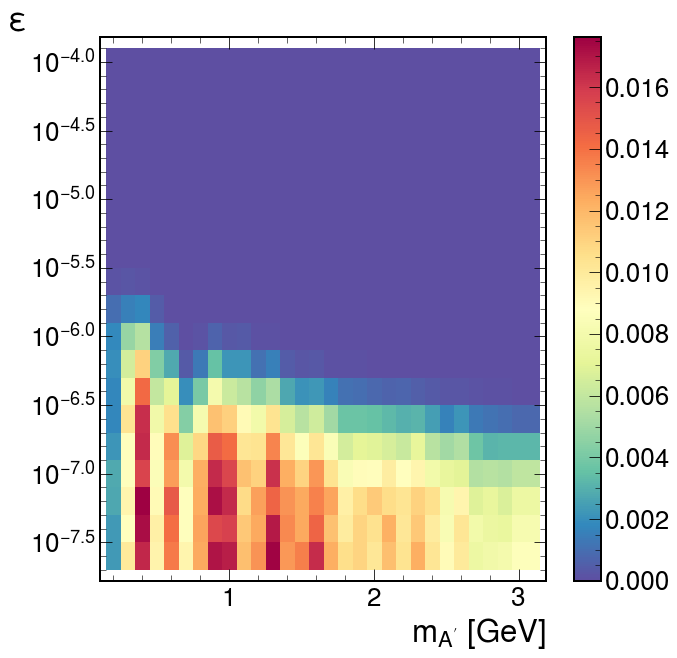

In [9]:
plot_acceptance(mass_3, coupling_3, Nevent_3, acceptance_3)

## 4. Pass both tracks and trigger

In [10]:
def scan_Ap_4(scan_dir):
    mass = []
    coupling = []
    Nevent = []
    acceptance = []

    #Loop through the files
    for filename in os.listdir(scan_dir):
        if filename.startswith("Brem"):
            
            try: 
                #Parse some basic info
                Ap_config = filename[:-5].split('_') #Remove the .root part and split by '_'

                #Load file and calculate total number of events
                dq_events = getData(os.path.join(scan_dir, filename), 'Events')

                #Total events
                n_events = len(dq_events["GenVertex"].x)
                Nevent.append(n_events)

                #Number of events reconstructed but not triggered
                n_reco = ak.sum(((ak.count(dq_events["Track_St1"].x, axis = 1) == 2) &\
                                (dq_events["fpga_trigger"].trigger[:,0] == 1))*dq_events['event_weight'].weight)

                acceptance.append(n_reco/n_events if n_events > 0 else 0)
                mass.append(float(Ap_config[1]))
                coupling.append(float(Ap_config[-1]))
                
            except:
                continue
            
#             print("---"*5)
#             print("Mass: ", Ap_config[1])
#             print("Coupling: ", Ap_config[-1])
#             print("Total number of events: ", n_events)
#             print("Number of events reconstructed", n_reco)
            
    return mass, coupling, Nevent, acceptance
            
mass_4, coupling_4, Nevent_4, acceptance_4 = scan_Ap_4(scan_dir)

/tmp/ipykernel_89756/1226374672.py:126: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(new_labels) # set new labels


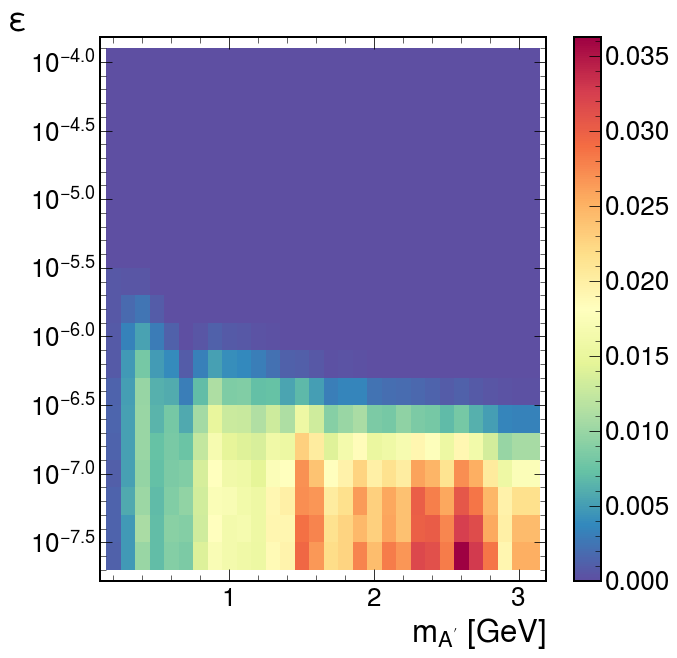

In [11]:
plot_acceptance(mass_4, coupling_4, Nevent_4, acceptance_4, hue_norm=(0, 0.05))

## 5. 1- fail all

In [ ]:
def scan_Ap_5(scan_dir):
    mass = []
    coupling = []
    Nevent = []
    acceptance = []

    #Loop through the files
    for filename in os.listdir(scan_dir):
        if filename.startswith("Brem"):
            
            try: 
                #Parse some basic info
                Ap_config = filename[:-5].split('_') #Remove the .root part and split by '_'

                #Load file and calculate total number of events
                dq_events = getData(os.path.join(scan_dir, filename), 'Events')

                #Total events
                n_events = len(dq_events["GenVertex"].x)
                Nevent.append(n_events)

                #Number of events reconstructed but not triggered
                n_reco = ak.sum(((~(ak.count(dq_events["Track_St1"].x, axis = 1) == 2)) &\
                                (~(dq_events["fpga_trigger"].trigger[:,0] == 1)))*dq_events['event_weight'].weight)

                acceptance.append(1 - n_reco/n_events if n_events > 0 else 0)
                mass.append(float(Ap_config[1]))
                coupling.append(float(Ap_config[-1]))
                
            except:
                continue
            
#             print("---"*5)
#             print("Mass: ", Ap_config[1])
#             print("Coupling: ", Ap_config[-1])
#             print("Total number of events: ", n_events)
#             print("Number of events reconstructed", n_reco)
            
    return mass, coupling, Nevent, acceptance
            
mass_5, coupling_5, Nevent_5, acceptance_5 = scan_Ap_5(scan_dir)

In [ ]:
plot_acceptance(mass_5, coupling_5, Nevent_5, acceptance_5)

## 6. Fpga trigger or Zije's trigger

In [5]:
def scan_Ap_6(scan_dir):
    mass = []
    coupling = []
    Nevent = []
    acceptance = []
    
    test_count = 0
    
    #Loop through the files
    for filename in os.listdir(scan_dir):
        if filename.startswith("Brem")  & (not filename.endswith("_DST.root")):
            
            #Parse some basic info
            Ap_config = filename[:-5].split('_') #Remove the .root part and split by '_'
    
            #Load file and calculate total number of events
            dq_events = getData(os.path.join(scan_dir, filename), 'Events')

            #Total events
            n_events = len(dq_events["GenVertex"].x)
            Nevent.append(n_events)

            #Implement trigger
            
            #Select events with only DP hits
            dp_hit_filter = (55 <= dq_events['hit'].detID) & (dq_events['hit'].detID <= 62)
            
            hit_y = dq_events['hit'].pos[dp_hit_filter]
            filtered_detID = dq_events['hit'].detID[dp_hit_filter]
            
            # Filter to require 4 hits (used to draw two lines)
            have_4_hits_event_mask = ak.sum(hit_y!=None, axis=1) == 4
            
            filtered_detID = filtered_detID[have_4_hits_event_mask]
            filtered_track = dq_events["Track_St1"].x[have_4_hits_event_mask]
            filtered_event_weight = dq_events['event_weight'].weight[have_4_hits_event_mask]
            filtered_fpga_trigger = dq_events["fpga_trigger"].trigger[:,0][have_4_hits_event_mask]
            
            #Calculate the events outside that is triggered
            not_filtered_fpga_trigger = dq_events["fpga_trigger"].trigger[:,0][~have_4_hits_event_mask]
            not_filtered_event_weight = dq_events['event_weight'].weight[~have_4_hits_event_mask]
            n_fpga_triggered = ak.sum(not_filtered_fpga_trigger*not_filtered_event_weight)
            
            #print(n_fpga_triggered)
            
            # Filter to require hits to stay in same quadrant
            same_quadrant_mask = (filtered_detID[:,0] + 4 == filtered_detID[:,2]) &\
                                (filtered_detID[:,1] + 4 == filtered_detID[:,3])
            
            #####------ End trigger implementation
            
            #Number of events triggered but not reco
            n_reco = ak.sum(((same_quadrant_mask == 1) |\
                            (filtered_fpga_trigger == 1))*filtered_event_weight)

            acceptance.append((n_reco+n_fpga_triggered)/n_events if n_events > 0 else 0)
            mass.append(float(Ap_config[1]))
            coupling.append(float(Ap_config[-1]))
            
#             test_count += 1
#             if test_count > 50: break
            
            
    return mass, coupling, Nevent, acceptance
            
mass_6, coupling_6, Nevent_6, acceptance_6 = scan_Ap_6(scan_dir)

/tmp/ipykernel_2321736/2639601488.py:113: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(new_labels) # set new labels


plot/18-04-2022DP_trigger_accept.pdf


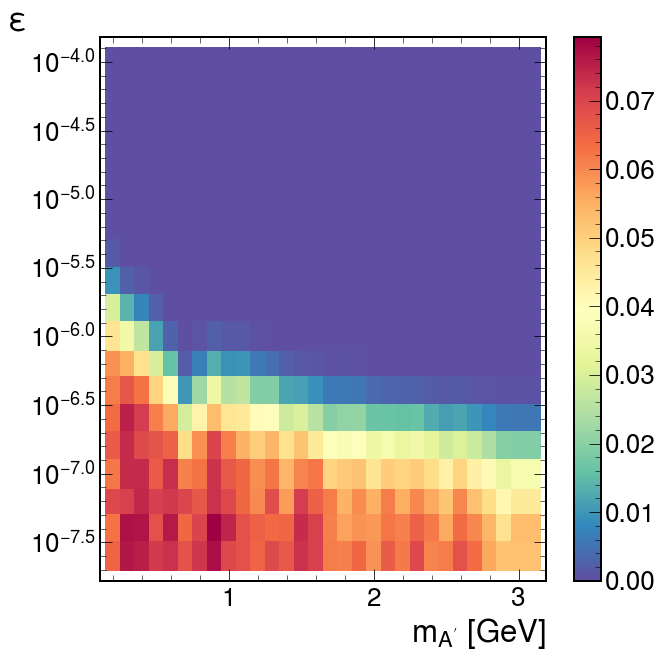

In [6]:
plot_acceptance(mass_6, coupling_6, Nevent_6, acceptance_6)
plt.savefig(save_path + "DP_trigger_accept.pdf", bbox_inches='tight')
print(save_path + "DP_trigger_accept.pdf")